# League of Legends
League of Legends è un videogioco Multiplayer Online Battle Arena (MOBA). Dieci giocatori divisi in due squadre combattono tra di loro per distruggere la base nemica.
Per gli scopi di questo progetto il riassunto non sarà esaustivo e eviterà di menzionare aspetti del gioco non inerenti al nostro studio.

La mappa su cui si svolge il gioco è la seguente

<img src="assets/league_of_legends_map.jpg" width=600/>

# In foto sono evidenziati:
## Nexus
Il Nexus è il cuore della base di una squadra, in foto è la gemma che si trova in basso a sinistra e in alto a destra per la squadra blu e rossa, rispettivamente. Il Nexus è protetto da tre inhibitor.

## Inhibitor
L'inhibitor è una struttura il cui scopo è proteggere il nexus. Una volta distrutto anche un solo inhibitor il Nexus viene scoperto e diventa vulnerabile ad attacchi nemici. Gli inhibitor sono protetti dalle torri presenti nelle lane.

## Lane
Ci sono tre corsie (lane) che partono dalla base blu e arrivano alla rossa, una in cima, in mezzo e in basso. Le corsie sono spesso occupate da giocatori che la difendono, in quanto per corsia sono presenti 2 torri per ciascuna squadra che proteggono gli Inhibitor. Una volta distrutte le due torri appartenenti ad una squadra in una lane, diventa vulnerabile l'inhibitor.

## Torre
La torre (in foto sono le statue sulle lane) è una struttura il cui scopo è proteggere la lane, per avanzare una squadra deve distruggere le torri presenti sulla lane per avanzare all'inhibitor

## Giungla
Tutto il territorio presente in mezzo alle lane, contiene mostri e obbiettivi. Gli obbiettivi appaiono a periodi prefissati nella partita, i principali sono

### Drake
Un drago appare periodicamente in basso a destra nella giungla, la squadra che lo sconfigge ottiene dei bonus

### Rift Herald
Un Rift Herald appare periodicamente verso inizio partita in alto a sinistra sulla mappa, la squadra che lo sconfigge può evocarlo per distruggere le torri nemiche

### Baron
Il Baron appare periodicamente verso fine partita, la squadra che lo sconfigge ottiene dei bonus temporanei

## Sintesi
Una squadra per vincere deve penetrare le difese di almeno una lane, distruggere l'inhibitor ad esso associata e finire distruggendo il Nexus. 

In [2]:
import os
import numpy as np
from urllib.request import urlretrieve
from zipfile import ZipFile

# constants
URL = "https://www.kaggle.com/api/v1/datasets/download/datasnaek/league-of-legends"
DATA_DIR = "data/"
ZIP_NAME = "compressed.zip"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

os.chdir(os.path.join(os.getcwd(), DATA_DIR))

if not os.path.exists(ZIP_NAME):
    # scarica il file dall'URL indicato
    urlretrieve(URL, ZIP_NAME)
    # apri il file zip ed estrai tutto il contenuto nella directory corrente
    with ZipFile(ZIP_NAME) as f:
        f.extractall()

In [3]:
import pandas as pd

games_data = pd.read_csv('games.csv', index_col=['gameId'])

In [4]:
import json

# Carica il file
with open("champion_info.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Accedi alla parte utile dei dati (data["data"] è un dizionario con campioni)
champion_data = data["data"]

# Trasforma il dizionario in DataFrame
df_champions_keyID = pd.DataFrame.from_dict(champion_data, orient="index")
# Carica il file
with open("champion_info_2.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Accedi alla parte utile dei dati (data["data"] è un dizionario con campioni)
champion_data = data["data"]

# Trasforma il dizionario in DataFrame
df_champions_nameID = pd.DataFrame.from_dict(champion_data, orient="index")

In [5]:
games_data["t1_hasDragonSoul"] = games_data["t1_dragonKills"] >= 4
games_data["t2_hasDragonSoul"] = games_data["t2_dragonKills"] >= 4

In [6]:
def win_conditional_prob(data: pd.DataFrame, on_column: str):
    intersect_count = len(data[(data["winner"] == 1) & (data[on_column] == 1)])
    on_column_count = len(data[data[on_column] == 1])
    
    return intersect_count / on_column_count

In [7]:
import numpy as np
import matplotlib.pyplot as plt

corr_frame = games_data.copy()
columns = ['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_hasDragonSoul', 't2_hasDragonSoul']

for column in columns:
    corr_frame[column] = corr_frame[column] == 1
    

corr_frame[columns].corr().style.format('{:.2f}', na_rep="")\
    .bar(align=0, vmin=-1, vmax=1, cmap="RdYlGn", height=50, width=60)

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_hasDragonSoul,t2_hasDragonSoul
winner,1.00,0.18,0.41,0.72,0.39,0.34,0.22,0.14,-0.15
firstBlood,0.18,1.00,0.22,0.16,0.06,0.14,0.11,0.03,-0.02
firstTower,0.41,0.22,1.00,0.40,0.15,0.32,0.26,0.08,-0.08
firstInhibitor,0.72,0.16,0.40,1.00,0.42,0.32,0.24,0.16,-0.11
firstBaron,0.39,0.06,0.15,0.42,1.00,0.17,0.13,0.16,-0.02
firstDragon,0.34,0.14,0.32,0.32,0.17,1.00,0.19,0.21,-0.20
firstRiftHerald,0.22,0.11,0.26,0.24,0.13,0.19,1.00,0.06,-0.04
t1_hasDragonSoul,0.14,0.03,0.08,0.16,0.16,0.21,0.06,1.00,-0.05
t2_hasDragonSoul,-0.15,-0.02,-0.08,-0.11,-0.02,-0.20,-0.04,-0.05,1.00


In [8]:
win_probabilities = pd.DataFrame(
    {
        column: win_conditional_prob(games_data, column) for column in columns[1:]
    }, index=["Win Rate"]
)
win_probabilities.style.format('{:.2f}')\
    .bar(align=0, vmin=0, vmax=1, cmap="YlGn", height=50, width=50)

,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_hasDragonSoul,t2_hasDragonSoul
Win Rate,0.59,0.71,0.91,0.81,0.69,0.69,0.82,0.18


In [9]:
from sklearn.model_selection import train_test_split

In [ ]:
# Naive Bayes model for predicting win based on objectives

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

model_data = games_data.copy()

ternary_map = {
    0: 0,
    1: 1,
    2: -1,
}

for column in columns[1:]:
    model_data[column] = model_data[column].map(ternary_map)

model_columns = columns[1:] + ["t1_dragonKills", "t2_dragonKills", "t1_baronKills", "t2_baronKills"]

X, y = (games_data[model_columns], games_data["winner"] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
win_predictor = GaussianNB()
y_pred = win_predictor.fit(X_train, y_train).predict(X_test)

f1_score(y_test, y_pred)

0.874280912675328

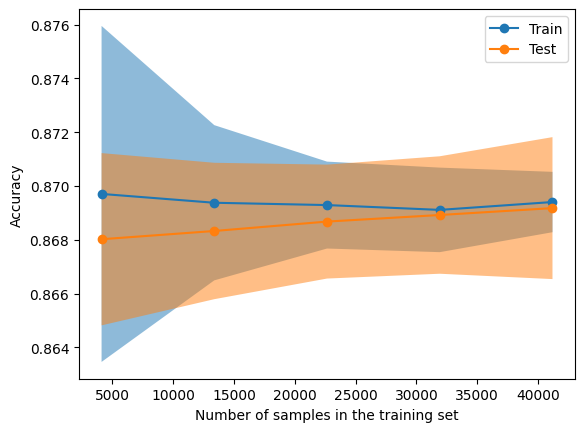

In [11]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

# learning score e training score

LearningCurveDisplay.from_estimator(
    win_predictor, 
    X = X, 
    y = y,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = ShuffleSplit(n_splits=25, test_size=0.2, random_state=0),
    score_type = "both",
    n_jobs = 4,
    line_kw = {"marker": "o"},
    std_display_style = "fill_between",
    score_name = "Accuracy",
)

In [13]:
# Bernoulli Naive Bayes for predicting win based on first objectives

from sklearn.naive_bayes import BernoulliNB

model_columns = columns[1:]

for column in model_columns:
    model_data[column] = model_data[column] == 1

X, y = (model_data[model_columns], model_data["winner"] == 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
win_predictor = BernoulliNB()
y_pred = win_predictor.fit(X_train, y_train).predict(X_test)

print((y_test == y_pred).sum() / len(X_test))

0.8469605748689066


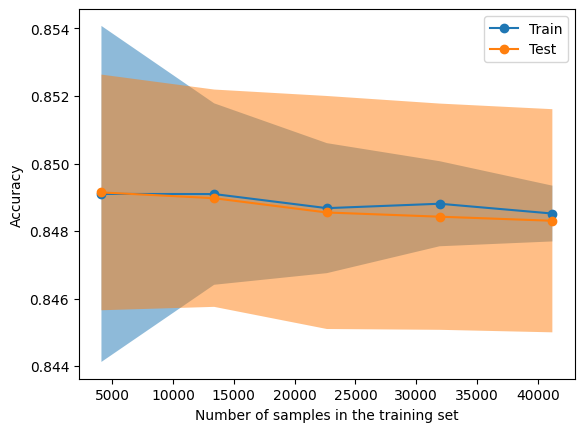

In [14]:
# learning score e training score

LearningCurveDisplay.from_estimator(
    win_predictor, 
    X = X, 
    y = y,
    train_sizes = np.linspace(0.1, 1.0, 5),
    cv = ShuffleSplit(n_splits=25, test_size=0.2, random_state=0),
    score_type = "both",
    n_jobs = 4,
    line_kw = {"marker": "o"},
    std_display_style = "fill_between",
    score_name = "Accuracy",
)

In [ ]:
games_data.columns

Index(['creationTime', 'gameDuration', 'seasonId', 'winner', 'firstBlood',
       'firstTower', 'firstInhibitor', 'firstBaron', 'firstDragon',
       'firstRiftHerald', 't1_champ1id', 't1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2id', 't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3id',
       't1_champ3_sum1', 't1_champ3_sum2', 't1_champ4id', 't1_champ4_sum1',
       't1_champ4_sum2', 't1_champ5id', 't1_champ5_sum1', 't1_champ5_sum2',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't1_ban1', 't1_ban2', 't1_ban3', 't1_ban4',
       't1_ban5', 't2_champ1id', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2id', 't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3id',
       't2_champ3_sum1', 't2_champ3_sum2', 't2_champ4id', 't2_champ4_sum1',
       't2_champ4_sum2', 't2_champ5id', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills',